# SPIRE Aperture Photometry for Point Sources

The method is outlined in [the SPIRE Handbook](http://herschel.esac.esa.int/Docs/SPIRE/spire_handbook.pdf), section 5.12.1 provdes the guidelines. This notebook just shows one practical example.

You have to download the extended calibrated level-2 maps (extdPxW) which are used in this example. This can be done through the Herschel Science Archive or directly from the link in the notebook.

For this exercise we are going to use a known stellar calibrator: $\beta$ And. We select one arbitrary observation of the target: [OBSID 1342212366 from Herschel Operational Day 603]( http://archives.esac.esa.int/hsa/aio/jsp/postcardPage.jsp?OBSERVATION_OID=8613833).

The model flux densities in the SPIRE bands (Decin et al. 2007) are (430, 217, 105) mJy at (250, 350, 500) µm. 

In [136]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [137]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import visualization
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.table import hstack

In [139]:
hdu = dict()
spire_bands = ['250','350','500']
obsid = 1342212366
for band in spire_bands:
    filex = "betaAnd-%i-%s.fits.gz"%(obsid,band)
    hdu[band] = fits.open(filex)
#

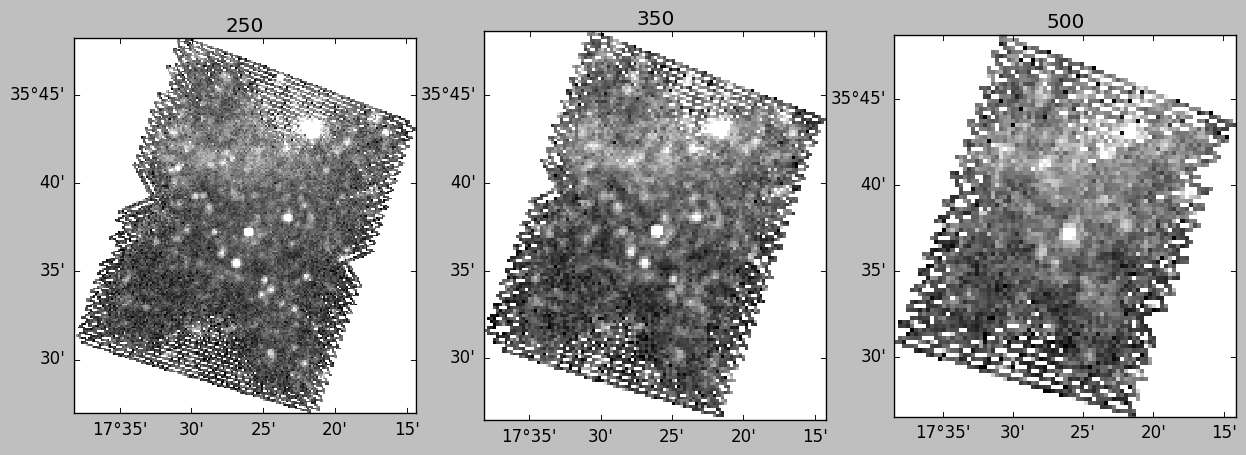

In [140]:
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # colour cut percentage
for k,band in enumerate(spire_bands):
    wcs = WCS(hdu[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title("%s"%band)
    img_scaled = visualization.scale_image(hdu[band]['image'].data,percent=pp)
    ax.imshow(img_scaled,cmap=plt.cm.gray,origin='lower',interpolation='nearest')

## Converting the input maps from MJy/sr to Jy/pixel

These are the steps
1. Convert to point-source calibration by dividing by KPtoE
2. Divide by $\Omega_\mathrm{pipe}$

After these two steps the maps should be in Jy/pixel

In [141]:
KPtoE = {'250': 90.646, '350': 51.181, '500': 23.580}
omega_pipe = {'250': 469.35, '350': 831.27, '500': 1804.31} # arcsec^2
for band in spire_bands:
    wcs = WCS(hdu[band]['image'].header)
    pixscale = wcs.wcs.cdelt[1]*3600.0
    hdu[band]['image'].data = pixscale**2*hdu[band]['image'].data/KPtoE[band]/omega_pipe[band]
    hdu[band]['image'].header['BUNIT'] = 'Jy/pixel'

Now the maps are in Jy/pixel. Let's define the coordinates of the target $\beta$ Andromeda:

In [142]:
# beta And coordinates
ra_c = 17.43504
dec_c = 35.62010
beta_And = SkyCoord(ra=ra_c * u.deg, dec=dec_c * u.deg, frame='icrs')
#

And define the apertures for the target, and the background. We use the aperture sizes as described in the SPIRE Handbook, table 5.8.

In [143]:
aperture = dict()
aperture['250'] = SkyCircularAperture(beta_And, r=22. * u.arcsec)
aperture['350'] = SkyCircularAperture(beta_And, r=30. * u.arcsec)
aperture['500'] = SkyCircularAperture(beta_And, r=40. * u.arcsec)
# now the background annuli
back = SkyCircularAnnulus(beta_And, r_in = 60.0*u.arcsec, r_out=90.0*u.arcsec)

Next is the actual measurement of the total flux within the target aperture and the background annulus. We do the background subtraction within the loop over the bands.

Few comments:
* the aperture areas can only be calculated if the aperture is conveted to pixels. To do this the method to_pixlel() needs a WCS.
* The final result is in Jy

In [144]:
photo = dict()
bkg_photo = dict()
result = dict()
for band in spire_bands:
    photo[band] = aperture_photometry(hdu[band]['image'], aperture[band])
    bkg_photo[band] = aperture_photometry(hdu[band]['image'], back)
    wcs = WCS(hdu[band]['image'].header)
    bkg_area = back.to_pixel(wcs).area()
    aper_area = aperture[band].to_pixel(wcs).area()
    result[band] = photo[band]['aperture_sum'][0] - aper_area*bkg_photo[band]['aperture_sum'][0]/bkg_area
    print (band,result[band][0], 'Jy')

250 0.329737814589 Jy
350 0.172821352857 Jy
500 0.0902212148151 Jy


Fow all the subsequent corrections we need the source spectrum, as the calculated flux density is for a source with $\nu F_\nu$ = const. Our assumption is that in the SPIRE bands $\beta$ And has a powerlaw spectrum with an index 2. In this case we can the tables in the SPIRE Handbook.

Next we need to apply the beam correction factor (Table 5.4 in Handbook).

In [145]:
kbeam = {'250': 1.0446, '350': 1.0434, '500': 1.0746} # powerlaw with alpha=2
for band in spire_bands:
    result[band] = result[band]*kbeam[band]
    print (band,result[band][0],'Jy')

250 0.34444412112 Jy
350 0.180321799571 Jy
500 0.0969517174403 Jy


Next we need to apply the colour correction KColP (Table 5.6)

In [146]:
kcolp = {'250': 0.9454, '350': 0.9481, '500': 0.9432} # powerlaw with alpha=2
for band in spire_bands:
    result[band] = result[band]*kcolp[band]
    print (band,result[band][0],'Jy')
    

250 0.325637472107 Jy
350 0.170963098173 Jy
500 0.0914448598897 Jy


And finally the aperture correction, which is also source SED dependent (Table 5.8). Note that we use the standard apertures of (22,30,40) arcsec. For different ones the user has to use the beam profiles from the SPIRE calibration context and dervie the correction.

In [147]:
kaper = {'250': 1.28, '350': 1.242, '500': 1.2610}
for band in spire_bands:
    result[band] = result[band]*kaper[band]
    print (band,result[band][0],'Jy')


250 0.416815964297 Jy
350 0.212336167931 Jy
500 0.115311968321 Jy


And finally let's compare with Decin et al. (2007) models:

In [148]:
model = {'250': 430, '350': 217, '500': 105} # mJy
print ('band,measured,model,model/measured')
for band in spire_bands:
    print (band,result[band][0]*1000, model[band], model[band]/result[band][0]/1000.0)


band,measured,model,model/measured
250 416.815964297 430 1.03163035208
350 212.336167931 217 1.02196437901
500 115.311968321 105 0.910573304133


We can visualise the apertures and the background annuli just to make sure they make sense.

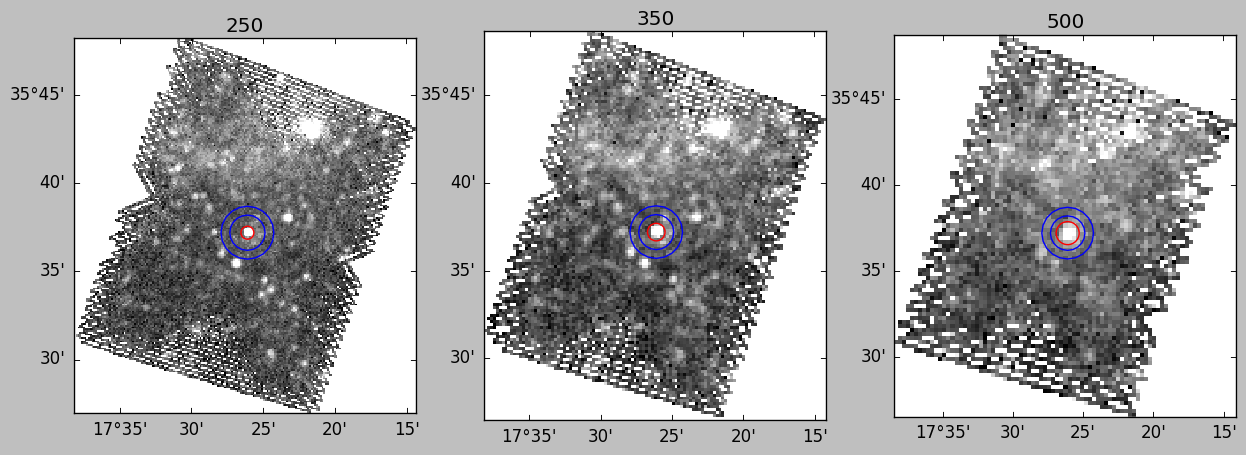

In [149]:
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # colour cut percentage
for k,band in enumerate(spire_bands):
    wcs = WCS(hdu[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title("%s"%band)
    img_scaled = visualization.scale_image(hdu[band]['image'].data,percent=pp)
    ax.imshow(img_scaled,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    aperture[band].to_pixel(wcs).plot(ax=ax,color='r')
    back.to_pixel(wcs).plot(ax=ax,color='b')